In [1]:
import scanpy as sc
import muon as mu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [208]:
import muon as mu
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad

import torch
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

# cell seged mouse thymus

In [2]:
data_path = "/home/wuxinchao/data/project/spatial-CITE-seq/sc_st_attention_integration/analysis/"
rna_path = f"{data_path}B01825A4_rna.h5ad"
prot_path = f"{data_path}B01825A4_protein.h5ad"

In [3]:
rna_adata = sc.read_h5ad(rna_path)
prot_adata = sc.read_h5ad(prot_path)

In [6]:
# rna_adata, prot_adata
rna_adata.obsm["spatial"][:,0].shape

(343476,)

In [14]:
rna_adata = rna_adata[rna_adata.obs["area"]>100,:]
prot_adata = prot_adata[prot_adata.obs.area > 100, :]

In [15]:
# rna_adata.obs.area
rna_adata, prot_adata

(View of AnnData object with n_obs × n_vars = 55196 × 25818
     obs: 'area'
     uns: '__type', 'pp', 'spatial'
     obsm: 'bbox', 'contour', 'spatial',
 View of AnnData object with n_obs × n_vars = 55170 × 199
     obs: 'area'
     uns: '__type', 'pp', 'spatial'
     obsm: 'bbox', 'contour', 'spatial')

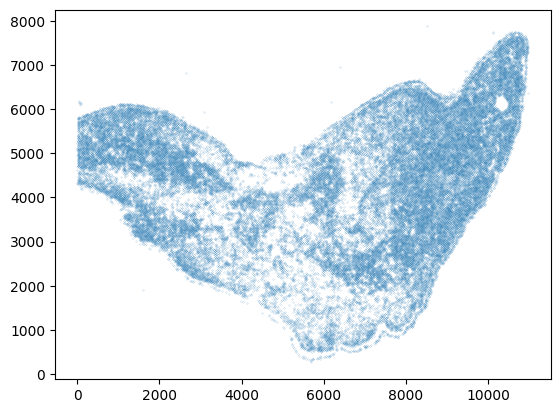

In [16]:
plt.scatter(rna_adata.obsm["spatial"][:,0],rna_adata.obsm["spatial"][:,1], s=0.01)

In [25]:
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

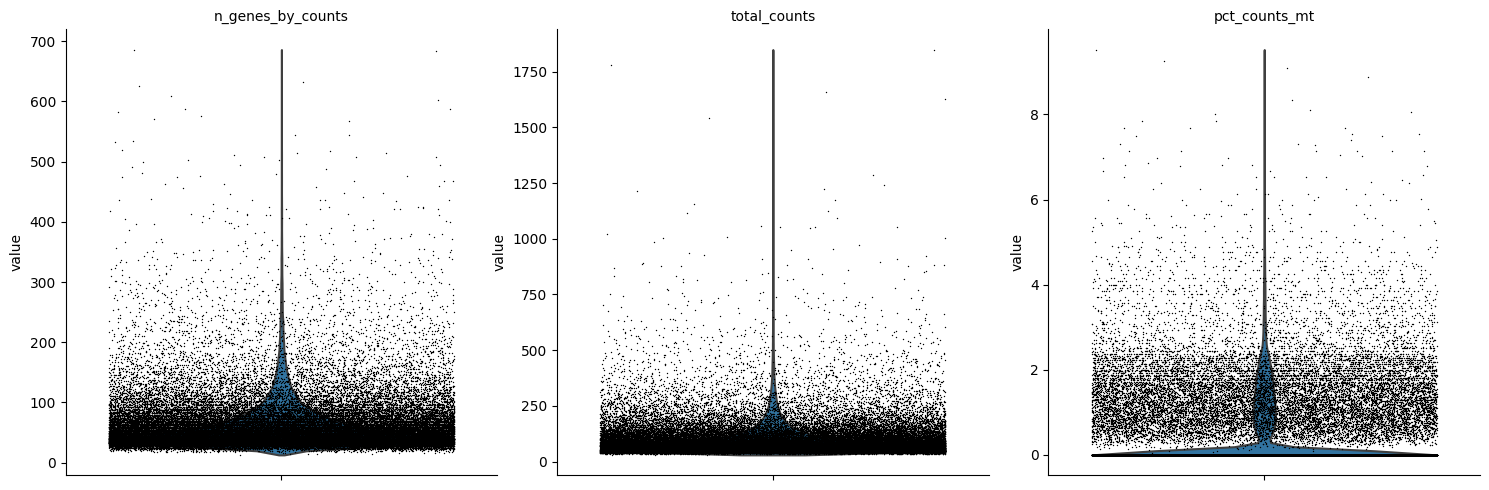

In [26]:
sc.pl.violin(rna_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [27]:
rna_adata.layers["counts"] = rna_adata.X.copy()

In [28]:
rna_adata_tmp = rna_adata.copy()

In [31]:
rna_adata_tmp = rna_adata_tmp[rna_adata_tmp.obs.n_genes_by_counts < 500, :]
rna_adata_tmp = rna_adata_tmp[rna_adata_tmp.obs.total_counts < 1000, :]
rna_adata_tmp = rna_adata_tmp[rna_adata_tmp.obs.n_genes_by_counts > 10, :]
rna_adata_tmp = rna_adata_tmp[rna_adata_tmp.obs.total_counts > 20, :]

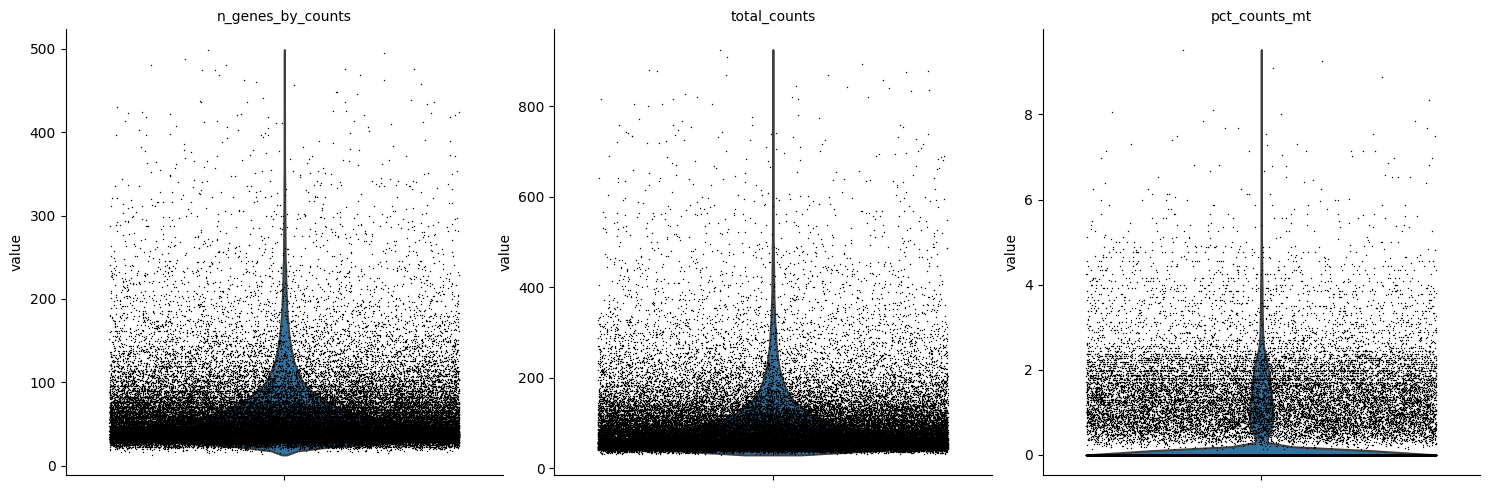

In [32]:
sc.pl.violin(rna_adata_tmp, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [33]:
rna_adata = rna_adata_tmp.copy()

In [34]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)
rna_adata.obs_names_make_unique()

In [35]:
sc.pp.highly_variable_genes(
    rna_adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    layer="counts",
)

In [36]:
sc.tl.pca(rna_adata, svd_solver='arpack')
sc.pp.neighbors(rna_adata, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna_adata, resolution=.75)
sc.tl.umap(rna_adata, spread=1., min_dist=.5, random_state=42)

In [37]:
sc.pp.calculate_qc_metrics(prot_adata, percent_top=None, log1p=False, inplace=True)

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


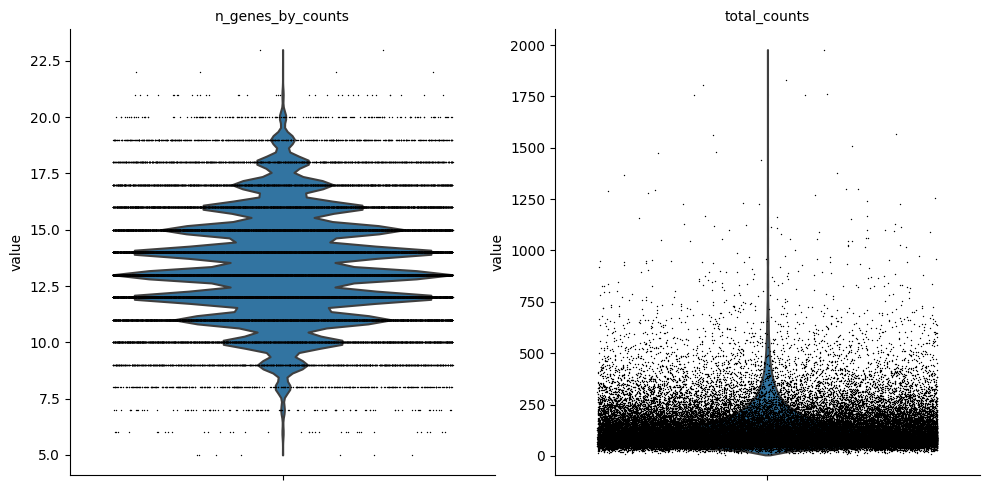

In [130]:
sc.pl.violin(prot_adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [131]:
prot_adata = prot_adata[prot_adata.obs.n_genes_by_counts > 4, :]
prot_adata = prot_adata[prot_adata.obs.total_counts < 2000, :]
prot_adata = prot_adata[prot_adata.obs.total_counts > 100, :]

In [132]:
prot_adata, rna_adata

(View of AnnData object with n_obs × n_vars = 28456 × 26
     obs: 'area', 'n_genes_by_counts', 'total_counts'
     var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: '__type', 'pp', 'spatial', 'log1p'
     obsm: 'bbox', 'contour', 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 55133 × 25818
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: '__type', 'pp', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
     obsm: 'bbox', 'contour', 'spatial', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities')

In [44]:
prot_adata.layers["counts"] = prot_adata.X.copy()
sc.pp.normalize_total(prot_adata, target_sum=1e4)
sc.pp.log1p(prot_adata)

In [164]:
common_mask = (rna_adata.obsm["spatial"][:, np.newaxis] == prot_adata.obsm["spatial"]).all(-1)
# common_points = rna_adata.obsm["spatial"][np.any(common_mask, axis=1)]
# common_points.shape[0]
rna_adata = rna_adata[np.any(common_mask, axis=1)]

In [176]:
common_mask_prot =  (prot_adata.obsm["spatial"][:, np.newaxis] == rna_adata.obsm["spatial"]).all(-1)
# common_points = prot_adata.obsm["spatial"][np.any(common_mask_prot, axis=1)]
port_adata = prot_adata[np.any(common_mask_prot, axis=1)]

In [194]:
prot_adata = prot_adata[rna_adata.obs_names,:]
prot_adata

View of AnnData object with n_obs × n_vars = 28427 × 26
    obs: 'area', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: '__type', 'pp', 'spatial', 'log1p'
    obsm: 'bbox', 'contour', 'spatial'
    layers: 'counts'

In [195]:
mdata = mu.MuData({
    "rna": rna_adata,
    "protein": prot_adata
})

In [196]:
mdata

MuData object with n_obs × n_vars = 28427 × 25844
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	28427 x 25818
      obs:	'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'__type', 'pp', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
      obsm:	'bbox', 'contour', 'spatial', 'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'distances', 'connectivities'
    protein:	28427 x 26
      obs:	'area', 'n_genes_by_counts', 'total_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
      uns:	'__type', 'pp', 'spatial', 'log1p'
      obsm:	'bbox', 'contour', 'spatial'
      layers:	'counts'

In [197]:
save_path = "/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/"

In [198]:
mdata.write_h5mu(f"{save_path}B01825A4_cellbin.h5mu")

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


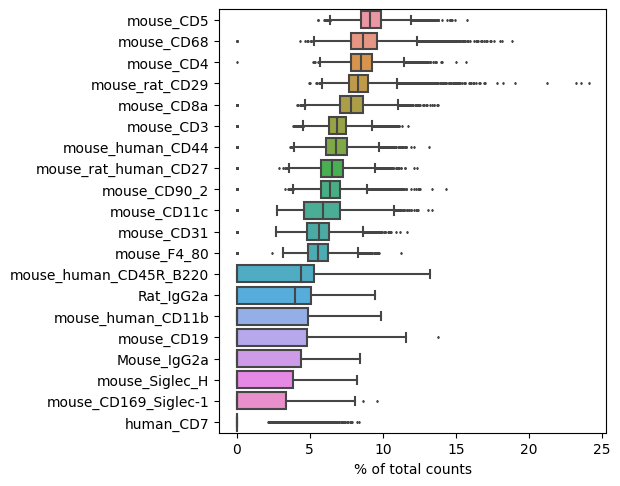

In [148]:
sc.pl.highest_expr_genes(prot_adata, n_top=20)

In [82]:
sc.pp.filter_genes(prot_adata, min_cells=3)

In [86]:
prot_adata = prot_adata[:,np.array(prot_adata.layers["counts"].sum(axis=0)) > 200]

In [89]:
prot_adata.var_names, save_path

(Index(['Mouse_IgG2a', 'Rat_IgG2a', 'human_CD119_(IFN-gamma_R_alpha_',
        'human_CD7', 'mouse_CD11c', 'mouse_CD169_Siglec-1', 'mouse_CD19',
        'mouse_CD3', 'mouse_CD31', 'mouse_CD4', 'mouse_CD43', 'mouse_CD5',
        'mouse_CD62L', 'mouse_CD63', 'mouse_CD68', 'mouse_CD8a', 'mouse_CD90_2',
        'mouse_CX3CR1', 'mouse_F4_80', 'mouse_NK-1_1', 'mouse_Siglec_H',
        'mouse_human_CD11b', 'mouse_human_CD44', 'mouse_human_CD45R_B220',
        'mouse_rat_CD29', 'mouse_rat_human_CD27'],
       dtype='object'),
 '/home/wuxinchao/data/st_cite_data/totalVI_reproducibility/data/')

# sc transfer

In [90]:
scCITE_mdata = mu.read_h5mu(f"{save_path}scCITE_intersect.h5mu")
scCITE_mdata

MuData object with n_obs × n_vars = 32648 × 13658
  2 modalities
    rna:	32648 x 13548
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
      uns:	'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances'
    protein:	32648 x 110
      obs:	'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'n_counts', 'panel'
      uns:	'log1p'

In [199]:
highly_variable = pd.read_csv(f"{save_path}/scCITE_hvg.csv")

In [200]:
# rna_adata[:,highly_variable.iloc[:,0]]
rna_adata_hvg_transfer = rna_adata[:, rna_adata.var_names.isin(highly_variable.iloc[:,0].to_list())]
rna_adata_hvg_transfer

View of AnnData object with n_obs × n_vars = 28427 × 3852
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '__type', 'pp', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
    obsm: 'bbox', 'contour', 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

In [201]:
rna_adata_hvg_transfer, prot_adata

(View of AnnData object with n_obs × n_vars = 28427 × 3852
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: '__type', 'pp', 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap'
     obsm: 'bbox', 'contour', 'spatial', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'counts'
     obsp: 'distances', 'connectivities',
 View of AnnData object with n_obs × n_vars = 28427 × 26
     obs: 'area', 'n_genes_by_counts', 'total_counts'
     var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
     uns: '__type', 'pp', 'spatial', 'log1p'
     obsm: 'bbox', 'contour', 'spatial'
     layers: 'counts')

In [202]:
# new_exp = np.zeros_like((rna_adata_hvg_transfer.shape[0], len(highly_variable)-1))
highly_variable.index = highly_variable.iloc[:,0]
highly_variable = highly_variable.T
highly_variable = highly_variable.drop('0')

In [203]:
tmp_exp = rna_adata_hvg_transfer.X.A

In [204]:
for i, gene_name in enumerate(rna_adata_hvg_transfer.var_names):
    highly_variable[gene_name] = tmp_exp[:,i]
    if i % 10 == 0:
        print(i)
highly_variable = highly_variable.fillna(0)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

In [97]:
list1 = [i[:-1] for i in scCITE_mdata["protein"].var_names.str.replace("ADT_","").str.split("_")]
list2 = prot_adata.var_names.to_list()
result = {}
for i, protein1 in enumerate(list1):
    for j, protein2 in enumerate(list2):
        if ''.join(filter(str.isalnum, protein1[0].lower())) in ''.join(filter(str.isalnum, protein2.lower())):
            result[protein1[0]] = [i, j]
            break
            
result

{'CD11c': [6, 4],
 'CD169(Siglec-1)': [17, 5],
 'CD19': [21, 6],
 'CD29': [40, 24],
 'CD4': [52, 9],
 'CD43': [54, 10],
 'CD45': [55, 23],
 'CD45R-B220': [58, 23],
 'CD5': [61, 11],
 'CD62L': [64, 12],
 'CD63': [66, 13],
 'CD68': [68, 14],
 'CD8a': [75, 15],
 'CD90.2': [78, 16],
 'CX3CR1': [80, 17],
 'F4-80': [82, 18],
 'NK-1.1': [94, 19],
 'SiglecH': [97, 20]}

In [116]:
len(result)

18

In [205]:
new_prot_exp = pd.DataFrame(columns = scCITE_mdata["protein"].var_names)
for protein in result:
    new_prot_exp[new_prot_exp.columns[result[protein][0]]] = prot_adata.X.A[:, result[protein][1]]
new_prot_exp = new_prot_exp.fillna(0)

In [206]:
# new_prot_exp.shape, highly_variable.shape
# highly_variable = highly_variable[:3999]

((28427, 110), (28427, 4000))

In [220]:
from utils import build_adjacency_matrix_torch
import torch

model_choice = "Graph Cross Attention"

rna_input_dim = highly_variable.shape[1] - 1 
prot_input_dim = new_prot_exp.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_adata_hvg_transfer.obsm["spatial"], T=0, alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((highly_variable.values[:,:3999], new_prot_exp.values), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 1
num_val = 0.4
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [221]:
# loading the pre-trained model
from model import GraphCrossAttn

model = GraphCrossAttn(
    rna_input_dim=rna_input_dim,
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks,
).to(device)

# load the pre-trained model
# model.load_state_dict(torch.load("../save_model/scCITE_intersect_hvg.pt")["model"])

In [222]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.85,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses= trainer.fine_tune(model=model, epochs=10, 
                    model_name="scCITE_intersect_hvg.pt", save_name="sc_stereo_CITE_thymus_cellbin_transfer.pt")

Epoch 1/10, Loss: 0.5213588072193993
Epoch 2/10, Loss: 0.2180318789349662
Epoch 3/10, Loss: 0.20594607359833186
Epoch 4/10, Loss: 0.18937424653106266
Epoch 5/10, Loss: 0.16645309461487665
Epoch 6/10, Loss: 0.1457552989323934
Epoch 7/10, Loss: 0.13205029798878565
Epoch 8/10, Loss: 0.12259828084044987
Epoch 9/10, Loss: 0.1140691285332044
Epoch 10/10, Loss: 0.10397078875038358


In [223]:
model.load_state_dict(torch.load("../save_model/best_sc_stereo_CITE_thymus_cellbin_transfer.pt")["model"])

<All keys matched successfully>

In [224]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [225]:
np.save("../data/GraphCrossRNArecon_mouse_thymus_stereoCITE_cellbin_hvg_transfer.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_mouse_thymus_stereoCITE_cellbin_hvg_transfer.npy", prot_recon)
np.save("../data/GraphCrossEmbedding_mouse_thymus_stereoCITE_cellbin_hvg_transfer.npy", embedding)

# sp integrate

In [226]:
rna_adata_subset = rna_adata[:, rna_adata.var["highly_variable"]]

In [227]:
from utils import build_adjacency_matrix_torch

model_choice = "Graph Cross Attention"

rna_input_dim = rna_adata_subset.shape[1]
prot_input_dim = prot_adata.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_adata_subset.obsm["spatial"], T=0, alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_adata_subset.X.A, prot_adata.X.A), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.4
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [228]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.85,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 237.89388 val_loss: 57.81787
Epoch 2/20 train_loss: 56.41326 val_loss: 54.48551
Epoch 3/20 train_loss: 54.59519 val_loss: 53.71435
Epoch 4/20 train_loss: 53.88728 val_loss: 53.14246
Epoch 5/20 train_loss: 52.38507 val_loss: 50.53409
Epoch 6/20 train_loss: 45.74089 val_loss: 40.17335
Epoch 7/20 train_loss: 34.41464 val_loss: 28.56504
Epoch 8/20 train_loss: 24.74527 val_loss: 22.02525
Epoch 9/20 train_loss: 19.05931 val_loss: 16.49983
Epoch 10/20 train_loss: 14.19699 val_loss: 12.99546
Epoch 11/20 train_loss: 11.61218 val_loss: 11.08016
Epoch 12/20 train_loss: 10.04514 val_loss: 9.69517
Epoch 13/20 train_loss: 8.93110 val_loss: 8.83337
Epoch 14/20 train_loss: 8.21362 val_loss: 8.27963
Epoch 15/20 train_loss: 7.73126 val_loss: 7.82985
Epoch 16/20 train_loss: 7.25611 val_loss: 7.36761
Epoch 17/20 train_loss: 6.83655 val_loss: 6.89943
Epoch 18/20 train_loss: 6.38190 val_loss: 6.37896
Epoch 19/20 train_loss: 5.86337 val_loss: 5.82142
Epoch 20/20 train_loss: 5.51698 val

In [229]:
model = trainer.best_model

In [230]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [232]:
np.save("../data/GraphCrossEmbedding_mouse_thymus_stereoCITE_cellbin_hvg_sp_intergrate.npy", embedding)

In [126]:
%who

alpha	 batch_size	 beta	 build_adjacency_matrix_torch	 common_mask	 common_mask_prot	 common_points	 data_path	 device	 
embedding_dim	 epochs	 gene_name	 heads	 hidden_dim	 highly_variable	 i	 j	 list1	 
list2	 lr	 mask_ratio	 mdata	 model_choice	 mu	 new_prot_exp	 np	 num_blocks	 
num_splits	 os	 pd	 permute	 plt	 preserve_rate	 prot_adata	 prot_input_dim	 prot_path	 
protein	 protein1	 protein2	 result	 rna_adata	 rna_adata_hvg_transfer	 rna_adata_tmp	 rna_input_dim	 rna_path	 
save_path	 sc	 scCITE_mdata	 sns	 tmp_exp	 torch	 
